<center><h1> Undirected graphical models (Markov random fields) </h1></center>
# 1. Basic
Directed graphical models (DGMs)  are forced to choose a direction for the edges, which is unnatural for some applications, such as modeling the correlationship between pixels in an image. An alternative is to use an **undirected graphical model (UGM)** ,also called a **Markov random field (MRF)**. These do not require us to specify edge orientations, and are much more natural for some problems.
## 1.1 Conditional independence (CI) properties of UGMs
* **global Markov property**. For sets of nodes $A,B$ and $C$, we say $x_A \bot x_B |x_C$ iff $C$ separates $A$ from $B$ in the graph $G$. This means that, when we remove all the nodes in $C$, there are no paths connecting any node in $A$ to any node in $B$. 
<img src="imgs/1.png" alt="drawing" width="200"/>
* **local Markov property**. The set of nodes that renders a node $t$ conditionally independent of all the other nodes in the graph is called $t$'s **Markov blanket**. It's obevously that a node's Markov blanket is its set of immediate neighbors.
* **pairwise Markov property**. Two nodes are conditionally independent given the rest if there is no direct edge between them.

# 2. Parameterization of MRFs
## 2.1 Hammersley-Clifford theorem
Since there is no topological ordering associated with an undirected graph, we can’t use the chain rule to represent $p(x_{1:V})$. So instead of associating conditional probability with each node, we associate **potential functions** with each maximal clique in the graph. The joint distribution is then defined to be proportional to the product of clique potentials. A positive distribution $p(x_{1:V})>0$ satisfies the CI properties of an undirected graph G iff p can be represented as a product of potential functions, one per maximal clique
$$
p(x_{1:V}|\theta)=\frac{1}{Z(\theta)}\prod_{c \in \mathcal{C}}\psi_c(\vec{x}_c|\theta_c)
$$
where $\mathcal{C}$ is the set of all the maximal cliques of G and $Z(\theta)$ is the **partition function**
<img src="imgs/2.png" alt="drawing" width="100"/>
For example, consider the MRF above, we can write $p$ as 
$$
p(x_{1:5}|\theta)=\frac{1}{Z(\theta)}\psi_{123}(x_1,x_2,x_3)\psi_{234}(x_2,x_3,x_4)\psi_{35}(x_3,x_5)
$$
## 2.2 Representing potential functions
We can convenient express the potential functions as exponentials
$$
\psi_c(\vec{x}_c)=exp\left\{-\frac{E(\vec{x}_c)}{kT}\right\}
$$
where $E(\vec{x}_c)$ is called the **energy function**, and the exponential representation is called the **Boltzmann distribution**. MRFs gives greater flexibility in choosing the potential functions, which can be done by viewing the potential function as expressing which configurations of the local variables are preferred to others (think it as minimum energy configuration). Global configurations that have a relatively high probability are those that find a good balance in satisfying the (possible conflicting) influences of the clique potentials.

A general approach is to define the **energy function** as a linear function of the parameters
$$
E(\vec{x}_c)=\phi_c(\vec{x}_c)^T \vec{\theta}_c
$$
where $\phi_c(\vec{x}_c)$ is a feature vector derived from the values of the variables $\vec{x}_c$. The resulting log probability has the form 
$$
log\,p(x_{1:V}|\theta)=-\frac{\sum_c\phi_c(\vec{x}_c)^T \vec{\theta}_c}{kT}-Z(\theta)
$$
This is known as **maximum entropy** or a **log-linear** model.
# 3. Examples of MRFs
## 3.1 Ising model
In simplest form, the Ising model consists of a $N \times N$ lattice of binary variables $x_{ij} \in \{-1,1\}$ that are locally connected with pairwise potentials.
<img src="imgs/3.png" alt="drawing" width="300"/>
We can define the energy function between lattice $i$ and lattice $j$ as 
$$
E_{ij}(x_i,x_j)=-Jx_ix_j
$$
which means the energy between lattice $i$ and lattice $j$ is $-J$ if $x_i$ and $x_j$ is the same and $J$ if $x_i$ and $x_j$ is different. The total energy of the system (Hamiltonian) is
$$
E=-J \sum_{x_i \sim x_j} x_ix_j
$$
where the sum is over all neighboring pairs of lattice. Statistical mechanics states that the probability of any particular configuration $c$ is
$$
p(c)=\frac{1}{Z}exp\left\{-\frac{E(c)}{kT}\right\}
$$

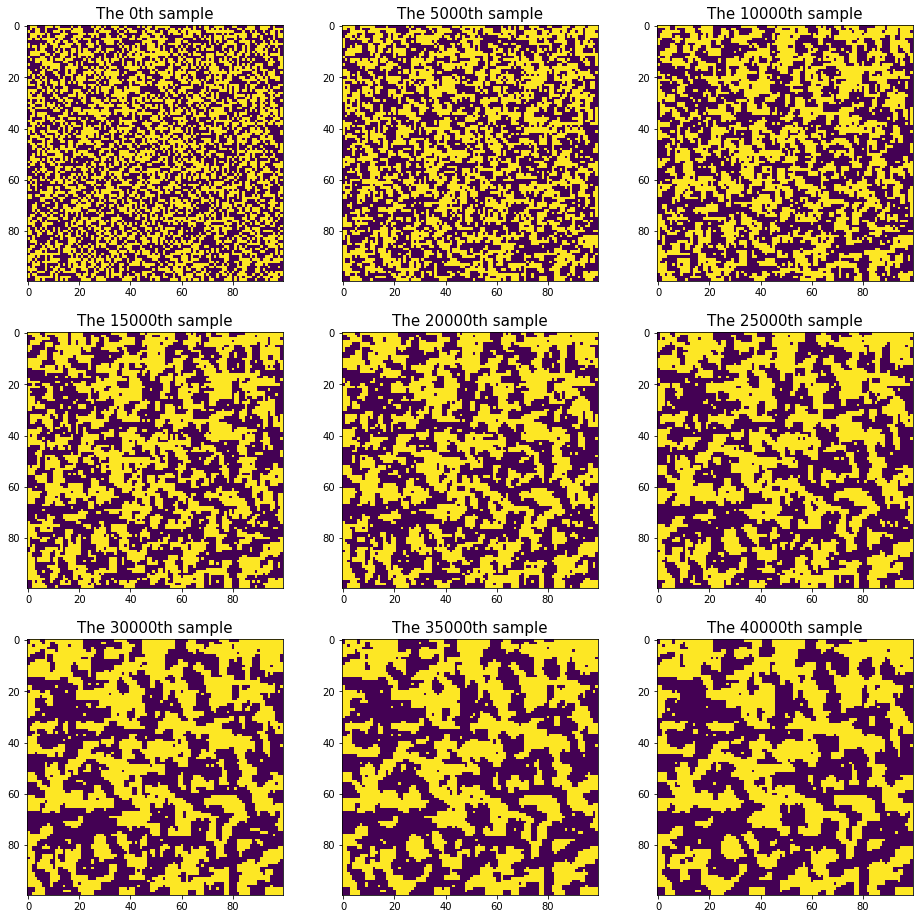

In [2]:
# Here we will sample from a 5*5 Ising model
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
np.random.seed(42)

model_size=100     # The size of the lattice array
pair_energy=10.0   # The J parameter
init_sample=np.random.rand(model_size,model_size)
init_sample[init_sample<=0.5]=-1
init_sample[init_sample>0.5]=1
sample_size=45000
plot_interval=int(sample_size/9)

def compute_energy(sample,x,y):
    left_energy= (0.0 if (x==0) else -sample[x-1,y]*sample[x,y]*pair_energy)
    right_energy= (0.0 if (x==model_size-1) else -sample[x,y]*sample[x+1,y]*pair_energy)
    down_energy= (0.0 if (y==0) else -sample[x,y-1]*sample[x,y]*pair_energy)
    up_energy= (0.0 if (y==model_size-1) else -sample[x,y]*sample[x,y+1]*pair_energy)
    return left_energy+right_energy+down_energy+up_energy

samples=np.array(init_sample)
#Perform the MH sampler
for i in range(sample_size):
    if i%plot_interval==0:
        plt.subplot(3,3,int(i/plot_interval)+1)
        plt.imshow(samples)
        plt.title("The %dth sample"%i,fontsize=15)
    #random select a pixel from the sample
    random_x=int(np.random.rand()*model_size)
    random_y=int(np.random.rand()*model_size)
    proposed_sample=np.copy(samples)
    proposed_sample[random_x,random_y]*=(-1)
    receive_prob=min(1.0,np.exp(compute_energy(samples,random_x,random_y)-
                               compute_energy(proposed_sample,random_x,random_y)))
    if np.random.rand()<receive_prob:
        samples=proposed_sample

## 3.2 Potts model
It is easy to generalize the Ising model to multiple discrete states $x_t \in \{1,2,\ldots,K\}$. It's common to define a energy function
$$
E_{ij}(x_i,x_j)=-J\mathbb{1}(x_i=x_j)
$$
which is called the **Potts model**. If $J >0$, neighboring nodes are encouraged to have the same label.

The **Potts model** can be used as a prior for **image segmentation**, since it says that neighboring pixels are likely to have the same discrete label and hence belong to the same segment.
\begin{align}
p(y,x|\theta)  &=p(y)\prod_t p(x_t|y_t,\theta) \\
               &=\left[\frac{1}{Z(J)}\prod_{s \sim t} \phi(y_s,y_t)\right]p(x_t|y_t,\theta) \\
               &=\left[\frac{1}{Z(J)}\prod_{s \sim t} e^{\frac{J\mathbb{1}(y_s=y_t)}{kT}}\right] p(x_t|y_t,\theta) \\
\end{align}
where $p(y)$ is the prior for the segmentation and $p(x_t|y_t,\theta)$ is the probability of observing pixel $x_t$ given that the corresponding segment belongs to class $k$.

## 3.3 Gaussian MRFs
Gaussian MRFs is a pairwise MRF of the following form
\begin{align}
p(x|\theta)        &=\prod_{s \sim t}\phi_{st}(x_s,x_t) \prod_t \phi_t(x_t) \\
\psi_{st}(x_s,x_t) &=exp\left(-\frac{1}{2}x_s\Lambda_{st}x_t\right)  \\
\psi_t(x_t)        &=exp\left(-\frac{1}{2}\Lambda_{tt}y_t^2+\eta_ty_t\right) \\
\end{align}
If $\Lambda_{st}=0$, then there is no pairwise term connecting $s$ and $t$,which can be use to efficiently learn the structure of the graph.

# 4. Learning
## 4.1 Training log-linear models using gradient methods
$$
p(\vec{x}|\vec{\theta})=\frac{1}{Z(\vec{\theta})}exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)\right)
$$
where $c$ indexes the cliques. The scaled log-likelihood is given by
\begin{align}
\mathcal{l}(\vec{\theta}) &=\frac{1}{N}\sum_{i}log\,p(\vec{x}_i|\vec{\theta})  \\
                    &=\frac{1}{N}\sum_{i}\left[\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)-log\, Z(\vec{\theta})\right]
\end{align}
The MRFs are in the exponential family, we know that this function is convex in $\theta$, so it has a unique global maximum which we can find using gradient-based optimizers.
$$
\frac{\partial \mathcal{l}}{\partial \vec{\theta}_c}=\frac{1}{N}\left[\phi_c(\vec{x}_c)-\frac{\partial}{\partial \theta_c(\vec{x}_c)}log\, Z(\vec{\theta})\right]
$$
The derivative of the log partition function wrt $\vec{\theta}_c$ is writen as
\begin{align}
\frac{\partial}{\partial \theta_c(\vec{x}_c)}log\, Z(\vec{\theta}) &=\frac{1}{Z(\vec{\theta})} \frac{\partial}{\partial \theta_c(\vec{x}_c)} Z(\vec{\theta}) \\
&=\frac{1}{Z(\vec{\theta})} \frac{\partial}{\partial \theta_c(\vec{x}_c)}\left[\int exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)\right)d\vec{x}\right] \\
&=\frac{1}{Z(\vec{\theta})}\left[\int \frac{\partial}{\partial \theta_c(\vec{x}_c)} exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)\right)d\vec{x}\right] \\
&=\frac{1}{Z(\vec{\theta})}\left[\int \phi_c(\vec{x}_c) exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)\right)d\vec{x}\right] \\
&=\int \phi_c(\vec{x}_c) \frac{exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c)\right)}{Z(\vec{\theta})}d\vec{x} \\
&=\mathbb{E}\left[\phi_c(\vec{x}_c)|\vec{\theta}\right]
\end{align}
Hence the gradient of the log likelihood is
$$
\frac{\partial \mathcal{l}}{\partial \vec{\theta}_c}=\frac{1}{N}\left[\phi_c(\vec{x}_c)\right]-\mathbb{E}\left[\phi_c(\vec{x}_c)|\vec{\theta}\right]
$$
We can view the gradient as a **moment matching** which match the expect feature vector according to the empirical distribution and the model's expect of the feature vactor. We should notice that the calculate of the model's expect of the feature vactor is quite computationally expensive, which makes UGM training much slower than DGM training. This problem arises because the intractable **partition function**.
## 4.2 Training partially observed log-linear models
Suppose we have missing data and/or hidden variables in our model.
$$
p(\vec{x},\vec{h}|\vec{\theta})=\frac{1}{Z({\vec{\theta}})}exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_c,\vec{h})\right)
$$
The log likelihood has the form
\begin{align}
l(\vec{\theta})  &=\frac{1}{N}\sum_{i}log\,p(\vec{x}_i|\vec{\theta}) \\
&=\frac{1}{N}\sum_i log\,\int p(\vec{x}_i,\vec{h}|\vec{\theta})dh \\
&=\frac{1}{N}\sum_i log\,\int \frac{1}{Z({\vec{\theta}})}exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh \\
\end{align}
The gradient is computed as
\begin{align}
\frac{\partial \mathcal{l}}{\partial \vec{\theta}_c} &= \frac{1}{N} \sum_i \left[\frac{\partial \mathcal{log\, \int exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh }}{\partial \vec{\theta}_c } \right]-\frac{\partial}{\partial \theta_c(\vec{x}_c)}log\, Z(\vec{\theta}) \\
&=\frac{1}{N} \sum_i \left[\frac{\int \phi_c(\vec{x}_{ic},\vec{h}) exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh}{\int exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh } \right]-\frac{\partial}{\partial \theta_c(\vec{x}_c)}log\, Z(\vec{\theta}) \\
&=\frac{1}{N} \sum_i \left[\frac{\int \phi_c(\vec{x}_{ic},\vec{h}) exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh}{\int exp\left(\sum_c \vec{\theta}_c^T \phi_c(\vec{x}_{ic},\vec{h})\right) dh } \right]-\mathbb{E}\left[\phi_c(\vec{x}_{ic},\vec{h})|\vec{\theta}\right]
\end{align}
## 4.3 Pseudo likelihood
Because of the intractable **partition function**, exact MLE estimation is difficult for UGM. One alternative is to maximize the **pseudo likelihood**
$$
\mathcal{l}_{PL}(\vec{\theta})=\frac{1}{N}\sum_{i=1}^N\sum_{d=1}^Dlog\,p(x_{id}|x_{i,-d},\theta)
$$
Compare this to the object for maximum likelihood
$$
\mathcal{l}(\vec{\theta}) =\frac{1}{N}\sum_{i}^Nlog\,p(\vec{x}_i|\vec{\theta})
$$
## 4.4 Stochastic maximum likelihood
Recall that the gradient of the log-likelihood for a fully obeserved MRF is given by
$$
\frac{\partial \mathcal{l}}{\partial \vec{\theta}_c}=\frac{1}{N}\left[\phi_c(\vec{x}_c)\right]-\mathbb{E}\left[\phi_c(\vec{x}_c)|\vec{\theta}\right]
$$
We can use the MCMC to approximate the model expectations $\mathbb{E}\left[\phi_c(\vec{x}_c)|\vec{\theta}\right]$. Of course, running MCMC to convergence at each step of the inner loop would be extremely slow. Fortunately,we can start the MCMC chain at its previous value, and just take a few steps. In otherwords, we sample $x^{s,k}$ by initializing the MCMC chain at $x^{s,k-1}$, and then run for a few iterations. This is valid since $p(\vec{x}|\vec{\theta}_k)$ is likely to be close to $p(\vec{x}|\vec{\theta}_{k-1})$, since we only changed the parameters a small amount.
# 5. Conditional random fields (CRFs)
A **conditional random field** or **CRF** is just a version of an MRF where all the clique potentials are conditioned on input features
$$
p(\vec{y}|\vec{x},\vec{w})=\frac{1}{Z(\vec{x},\vec{w})}\prod_c\psi_c(\vec{y}_c|\vec{x},\vec{w}_c)
$$
**A CRF can be thought of as a structured output extension of logistic regression**. We will usually assume a log-linear representation of the potentials
$$
\psi_c(\vec{y}_c|\vec{x},\vec{w}_c)=exp\left(\vec{w}_c^T \phi(\vec{x},\vec{y}_c) \right)
$$
where $\phi(\vec{x},\vec{y}_c)$ is a feature vector derived from the global inputs $\vec{x}$ and the local set of labels $\vec{y}_c$.
## 5.1  Chain-structure CRFs
The most widely used kind of CRF uses a chain-structured graph to model correlation amongst neighboring labels.
Traditionally, HMMs have been used for such tasks
$$
p(\vec{x},\vec{y}|\vec{w})=p(y_1|\vec{w})p(x_1|y_1,\vec{w})\prod_{t=2}^T p(y_t|y_{t-1},\vec{w})p(x_t|y_t,\vec{w})
$$
<img src="imgs/4.png" alt="drawing" width="150"/>
An HMM requires specifying a generative observation model $p(x_t|y_t,\vec{w})$, which can be difficult. Furthermore, each $x_t$ is required to be local, which is not proper.

An obvious way to make a discriminative version of an HMM is to define a model 
$$
p(\vec{y}|\vec{x},\vec{w})=\prod_t p(y_t|y_{t-1},x_t,\vec{w},\vec{x}_g)
$$
where $\vec{x}_g$ means some global features. This model is called **maximum entropy Markov model (MEMM)**. But this model suffers from a subtle problem known (rather obscurely) as the **label bias**
problem. The problem is that local features at time $t$ do not influence states prior to time $t$. The reason is that in MEMM, the information don't flow back.
<img src="imgs/5.png" alt="drawing" width="150"/>

Now consider a chain-structured CRF. This model has the form
$$
p(\vec{y}|\vec{x},\vec{w})=\frac{1}{Z(\vec{x},\vec{w})}\prod_{t=1}^{T-1}\psi(y_t,y_{t+1}|x_t,x_{t+1},\vec{x}_g,\vec{w})\prod_{t=1}^T\psi(y_t|x_t,\vec{x_g},\vec{w})
$$
The chain-structured CRF don't have **label bias** problem, but it's much slower to train due to the existence of partition function.
<img src="imgs/6.png" alt="drawing" width="150"/>

## 5.2 CRF training
The scaled log-likelihood becomes
\begin{align}
l(\vec{w}) &=\frac{1}{N}\sum_i log\, p(\vec{y}_i|\vec{x}_i,\vec{w}) \\
           &=\frac{1}{N}\sum_i\left[\sum_c \vec{w}_c^T \phi_c(\vec{y}_{ic},\vec{x}_i) -log\,Z(\vec{w},\vec{x}_i) \right]
\end{align}
The gradient becomes
\begin{align}
\frac{\partial l}{\partial \vec{w}_c} &=\frac{1}{N}\sum_i\left[\phi_c(\vec{y}_{ic},\vec{x}_i)-\frac{\partial}{\partial \vec{w}_c} log\, Z(\vec{w},\vec{x}_i)\right]   \\
                                      &=\frac{1}{N}\sum_i\left[\phi_c(\vec{y}_{ic},\vec{x}_i)-\mathbb{E}\left[\phi_c(\vec{y}_{ic},\vec{x}_i)\right]\right]
\end{align}
Note that we now have to perform inference for every single training case inside each gradient step, which is $O(N)$ times slower than the MRF case. This is because the partition function depends on the inputs $\vec{x}_i$.

In most applications of CRFs, the size of the graph structure can vary. Hence we need to use **parameter tying** to ensure we can define a distribution of arbitrary size. In the pairwise case, we can write the model as follows.
$$
p(\vec{y}|\vec{x},\vec{w})=\frac{1}{Z(\vec{w},\vec{x})} exp \left(\vec{w}^T \phi(\vec{y},\vec{x})\right)
$$
where $\vec{w}=\left[ \vec{w}_n,\vec{w}_e\right]$ are the node and edge parameters and
$$
\phi(\vec{y},\vec{x})=\left[\sum_t \phi_t(y_t,\vec{x}),\sum_{s \sim t}\phi_{st}(y_s,y_t,\vec{x})\right]
$$